# node2vec: Scalable Feature Learning for Networks (kdd2016)

- 读图，设置模型参数
- 计算点和边的alias table
- 有偏的随机游走生成节点序列
- 利用word2vec训练模型
- 结果展示和可视化

In [1]:
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
import random
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# 1.读图，设置模型参数
- 设置模型参数 设置图相关参数，如有向无向图/权重图等，还有模型系数，如p/q/embedding长度等
- 读图 使用networdx包直接加载edgelist
- 输入输出

In [2]:
def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    # 使用parser加载信息 
    parser = argparse.ArgumentParser(description="Run node2vec.")
    # 输入文件
    parser.add_argument('--input', nargs='?', default='./karate.edgelist',
                        help='Input graph path')
    # 输出文件
    parser.add_argument('--output', nargs='?', default='./emb/karate.emb',
                        help='Embeddings path')
    # emnedding维度
    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')
    # 节点序列长度
    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')
    # 随机游走次数
    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')
    # word2vec 窗口大小 word2vec参数
    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')
    # SGD优化时epoch数量，word2vec参数
    parser.add_argument('--iter', default=1, type=int,
                        help='Number of epochs in SGD')
    # 并行化核数 Word2vec参数
    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')
    # 参数p
    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')
    # 参数q
    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')
    # 权重
    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)
    # 有向无向
    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)
    
    return parser.parse_args(args=[])
#     return parser.parse_args()

In [3]:
def read_graph():
    # 权重图
    if args.weighted:
        # 路径、     data:为边数据指定字典键名称和类型的元组
        G = nx.read_edgelist(args.input, nodetype=int, data=(('weight',float)), create_using=nx.DiGraph())
    else: # 无权图
        G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1 # 把有向图weight定死
    # 无向操作
    if not args.directed:
        G = G.to_undirected()
    return G


34


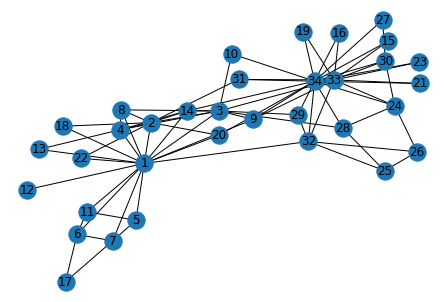

In [4]:
# 设置模型参数
args = parse_args()
# 读图
nx_G = read_graph()
print(len(nx_G)) # 点的个数

nx.draw(nx_G, with_labels=True)
plt.show()

# 计算点和边的alias table

In [5]:
"""
将四个事件排成一列，分为1，2，3，4。
每个概率乘以四（事件数）。

然后拼凑使每列值为 1，并保证每列最多只包含两个事件。

乘以事件数之后先将事件分成两部分，一个小于1（smaller），一个大于1（larger），
然后分别从这两部分中取数据，用大的补小的使其为 1，如果大的剩余值小于1，加入smaller中，
否则还是放回larger中，直到smaller或larger为空。
"""

def alias_set_up(probs):
    K = len(probs)  # 类别数
    q = np.zeros(K)  # 保存样本概率
    J = np.zeros(K, dtype=np.int)  # 保存补1的事件

    smaller = []
    larger = []
    
    # 将各个概率分成两组，一组的概率值大于1，一组概率值小于1
    for kk, prob in enumerate(probs):
        q[kk] = K * prob  # 遍历每个概率 乘以类别数
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    # 使用贪心算法，将概率值小于1的不断填满
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        #更新概率值
        q[large] = q[large] - (1 - q[small])
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)
    return J, q


"""
根据Alias Table
随机生成 1—N（事件数） 一个数，确定选中哪列，
然后再随机生成一个 0—1 的数，
根据概率判断是取样该列的事件还是该列用来补 1 的事件。

如选中第3列后产生的随机数小于 1/3 则选黄色事件3，否则选蓝色事件1。
"""
def alias_draw(J, q):
    K = len(J)
    kk = int(np.floor(np.random.rand() * K))
    # 取自己
    if np.random.rand() < q[kk]:
        return kk
    # 取alias table存的节点
    else:
        return J[kk]


In [6]:
class Graph():
    # 初始化设置参数
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q
        
    # 模拟随机游走开始于start_node
    def node2vec_walk(self, walk_length, start_node):
        G = self.G
        # 上一步计算出alias table 完成O(1)采样
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges
        
        walk = [start_node]
        
        # 直到生成长度为walk_length的节点序列为止
        while len(walk) < walk_length:
            cur = walk[-1]
            # 对邻居节点排序，目的是和alias table计算是的顺序对应起来
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) >0:
                # 节点序列只有一个节点的情况
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                # 节点序列大于一个节点的情况
                else:
                    # 看前一个节点，prev是论文中的节点t
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break
        return walk
    
    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print('Walk iteration:')
        for walk_iter in range(num_walks):
            print(str(walk_iter+1), '/', str(num_walks))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))
        return walks
                    
                    
    # 引导随机游动的转移概率预处理
    def preprocess_transition_probs(self):
        G = self.G
        is_directed = self.is_directed
        
        alias_nodes = {}
        # 节点概率alias sampling和归一化
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            noormalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs] #归一化
            alias_nodes[node] = alias_set_up(noormalized_probs) # alias sampling O(1)采样
            
            # 信息展示
            if node==2:
                print(unnormalized_probs)
                print(norm_const)
                print(noormalized_probs)
                print(alias_nodes[node])
                
        alias_edges = {}
        triads = {}
        # 边概率alias sampling和归一化
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1]) # 无向图要算两次，因为v和t邻居数可能不同
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1],edge[0])
                
        print('edges alias')
        print(alias_edges[(2,3)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges
        
        return
        
                
    def get_alias_edge(self, src, dst):
        """
        Get the alias edge setup lists for a given edge
        """
        G = self.G
        p = self.p
        q = self.q
        
        unnormalized_probs = []
        # 论文3.2.2节核心算法
        for dst_nbr in sorted(G.neighbors(dst)): #遍历目的节点的邻居
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
                
        # 归一化
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
        return alias_set_up(normalized_probs) # 对于任意一个概率列表都可以做alias sampling
        
                    

# 有偏的随机游走生成节点序列

In [7]:
def simulate_walks(self, num_walks, walk_length):
    #重复模拟每个节点的随机游走
    G = self.G
    walks = []
    nodes = list(G.nodes())
    
    print('Walk iteration:')
    for walk_iter in range(num_walks):
        print(str(walk_iter+1),'/', str(num_walks))
        
        #打乱节点顺序
        random.shuffle(nodes)
        for node in nodes:
            # node2vec_walk是一次有偏的随机游走
            walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))
    return walks
    

In [8]:
def node2vec_walk(self, walk_length, start_node):
    # 模拟一次随机游走
    G = self.G
    # 上一步计算出的alias table 完成O(1)采样
    alias_nodes = self.alias_nodes
    alias_edges = self.alias_edges
    
    walk = [start_node]
    # 直到生成长度为walk_length的节点序列为止
    while len(walk)<walk_length:
        cur = walk[-1]
        # 对邻居节点排序，目的是和alias table计算时的顺序对应起来
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs)>0:
            #节点序列只有一个的情况
            if len(walk) == 1:
                # alias_nodes[cur][0] -- alias table
                # alias_nodes[cur][1] -- probability table
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            # 节点序列大于一个节点的情况
            else:
                # 看前一个节点，prev是论文中的t节点
                prev = walk[-2]
                next1 = cur_nbrs[alias_draw(alias_edges[(prev,cur)][0],alias_edges[(prev,cur)[1]])] 
                walk.append(next1)
        else:
            break
    return walk

In [9]:
# 模型加载参数
# G = node2vec.Graph(nx_G, args.directed, args.p. args.q)
G = Graph(nx_G, args.directed, args.p, args.q)

# 信息展示1
print(G.G.nodes())

# 信息展示2
# G.is_directed
# G.p
# G.q

# 生成alias table
G.preprocess_transition_probs()
print("nodes and edges alias sampling")

[1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))
edges alias
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))
nodes and edges alias sampling


In [10]:
# 有偏的随机游走生成节点序列
walks = G.simulate_walks(args.num_walks, args.walk_length)
# 展示一个节点序列的长度
print(len(walks[0]))

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
80


In [11]:
walks # 训练语料

[[8,
  1,
  2,
  14,
  34,
  29,
  32,
  29,
  34,
  16,
  33,
  9,
  33,
  19,
  33,
  34,
  20,
  2,
  4,
  3,
  10,
  34,
  23,
  34,
  27,
  34,
  31,
  2,
  18,
  1,
  22,
  2,
  8,
  2,
  31,
  2,
  14,
  34,
  9,
  1,
  4,
  8,
  2,
  8,
  2,
  22,
  1,
  5,
  7,
  17,
  6,
  7,
  1,
  22,
  2,
  18,
  2,
  14,
  3,
  29,
  32,
  1,
  7,
  6,
  1,
  11,
  1,
  11,
  5,
  11,
  6,
  1,
  11,
  6,
  17,
  7,
  1,
  6,
  7,
  6],
 [33,
  16,
  34,
  21,
  34,
  14,
  3,
  2,
  20,
  1,
  9,
  3,
  1,
  13,
  4,
  14,
  2,
  18,
  2,
  3,
  28,
  24,
  30,
  33,
  3,
  28,
  25,
  32,
  25,
  32,
  26,
  24,
  28,
  3,
  4,
  1,
  4,
  13,
  1,
  9,
  33,
  30,
  34,
  20,
  34,
  24,
  28,
  34,
  19,
  34,
  32,
  26,
  25,
  32,
  25,
  26,
  32,
  29,
  34,
  20,
  1,
  12,
  1,
  2,
  31,
  2,
  18,
  2,
  14,
  2,
  22,
  2,
  14,
  2,
  22,
  1,
  4,
  2,
  31,
  2],
 [13,
  4,
  13,
  4,
  8,
  4,
  3,
  29,
  3,
  33,
  15,
  34,
  14,
  4,
  14,
  2,
  8,
  2,
  14,
  34,


# 利用word2vec训练模型

In [12]:
def learn_embedding(walks):
    # 通过使用SGD优化Skipgram目标来学习embedding
    # 将node的类型int转化为string
    # walks = [map(str, walk) for walk in walks]
    walk_lol = []
    for walk in walks:
        tmp = []
        for node in walk:
            tmp.append(str(node))
        walk_lol.append(tmp)
    #调用word2vec
    model = Word2Vec(walk_lol, size=args.dimensions, window=args.window_size, min_count=0, sg=1,workers=args.workers,iter=args.iter)
    # model.save_word2vec_format(args.output)
    # 保存embedding信息
    model.wv.save_word2vec_format(args.output)
    return model

In [13]:
model = learn_embedding(walks)

# 结果展示可视化

In [14]:
model['17'] # 节点17的特征

array([-0.09304535,  0.08647319,  0.06922857, -0.21103631,  0.0722431 ,
        0.33727333,  0.0445342 , -0.11609449,  0.03588363,  0.10334539,
        0.07842353, -0.14247715, -0.08015443, -0.16625257,  0.04356157,
       -0.09638586,  0.04734705,  0.07343068,  0.11319405, -0.05045526,
       -0.06593768,  0.18937732,  0.0844851 ,  0.04372216, -0.05572996,
        0.03813929, -0.09511303, -0.00858809,  0.09873797, -0.10353214,
        0.16472602,  0.00170395,  0.15815629, -0.05153663,  0.11636076,
        0.00067592, -0.10702778, -0.14007096, -0.00510662,  0.03043533,
        0.02338677,  0.05045146,  0.10596416, -0.07252119, -0.08312841,
       -0.06797791,  0.02444287, -0.248019  ,  0.0085215 , -0.01492921,
        0.20904455, -0.10853878, -0.08565895,  0.03371083, -0.10636902,
       -0.10112176,  0.15931885,  0.12420074, -0.19818316, -0.08260933,
       -0.10983594,  0.14013861,  0.12311807,  0.0687555 , -0.11612076,
       -0.17190267, -0.00188818, -0.15273774,  0.05606106,  0.25

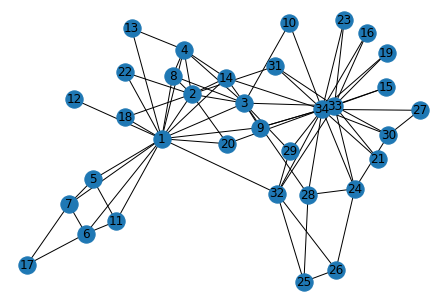

In [15]:
nx.draw(nx_G, with_labels=True)
plt.show()

In [16]:
# 相似节点组
print(model.similarity('17','6'))
print(model.similarity('7','6'))
print(model.similarity('7','5'))

0.9994627
0.9970668
0.9952487


In [17]:
print(model.similarity('34','33'))
print(model.similarity('34','9'))
print(model.similarity('34','31'))

0.9909038
0.9446868
0.98828924


In [18]:
print(model.similarity('17','25'))
print(model.similarity('7','25'))


0.5761301
0.6184825


In [19]:
model.wv.most_similar('34')

[('32', 0.9991911053657532),
 ('25', 0.9981615543365479),
 ('30', 0.9974561333656311),
 ('26', 0.9957784414291382),
 ('24', 0.9952033758163452),
 ('29', 0.9946041703224182),
 ('23', 0.9935464859008789),
 ('28', 0.9914390444755554),
 ('33', 0.9909037351608276),
 ('27', 0.9888952374458313)]

In [20]:
from scipy import spatial

def cos_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1,v2) #夹角

print(cos_similarity(model['17'], model['6']))
print(cos_similarity(model['7'],model['6']))
print(cos_similarity(model['7'], model['5']))

0.9994628429412842
0.9970667958259583
0.9952486753463745


In [21]:
print(cos_similarity(model['34'], model['33']))
print(cos_similarity(model['34'],model['9']))
print(cos_similarity(model['34'], model['31']))

0.9909036755561829
0.9446867108345032
0.9882892370223999


In [22]:
print(cos_similarity(model['17'], model['25']))
print(cos_similarity(model['7'],model['25']))

0.5761300325393677
0.6184824705123901


In [57]:
# k-means聚类
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import pandas as pd

embedding_node = []
for i in range(1,35):
    j = str(i)
    embedding_node.append(model[j])
    
embedding_node = np.matrix(embedding_node).reshape((34,-1))
y_pred = cluster.KMeans(n_clusters=3, random_state=9).fit_predict(embedding_node) 
y_pred

array([2, 1, 0, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

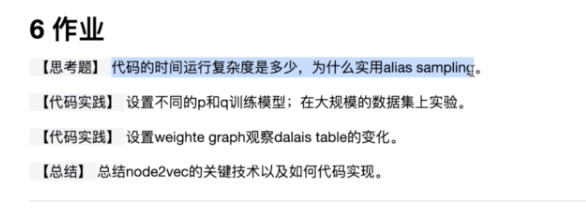

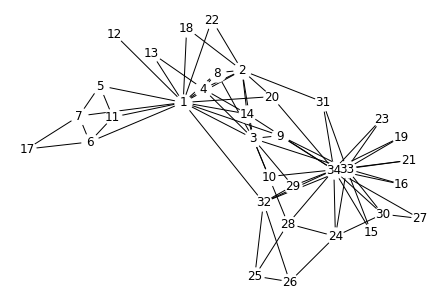

In [58]:
nx.draw(nx_G, with_labels=True,node_color='white')
plt.show()

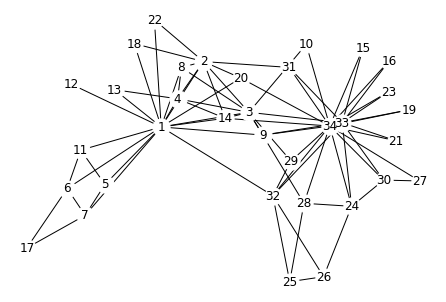

In [59]:
dict_label = dict(zip(nx_G,y_pred))
nx.draw(nx_G, with_labels=True,node_color='white')
plt.show()

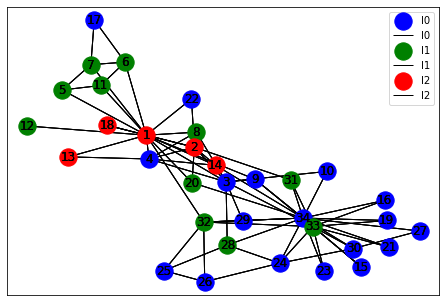

[1, 18, 14, 13, 2]

In [60]:
l0 = []
l1 = []
l2 = []
for i,node in enumerate(nx_G.nodes()):
    if y_pred[i] == 0:
        l0.append(node)
    elif y_pred[i] == 1:
        l1.append(node)
    else:
        l2.append(node)

pos=nx.spring_layout(nx_G) 
nx.draw(nx_G,pos, nodelist=l0, node_color='blue', label = "l0", with_labels=True)
nx.draw(nx_G,pos, nodelist=l1, node_color='green', label = "l1",  with_labels=True)
nx.draw(nx_G,pos, nodelist=l2, node_color='red', label = "l2", with_labels=True)

# nx.draw_networkx_edge_labels(nx_G, pos, labels = edge_labels,arrows=False)
# nx.draw_networkx_labels(G,pos,labels1,font_size=12,font_family='sans-serif')
plt.legend(numpoints = 1)
plt.axis('on')
plt.show()
l2

In [55]:
help(nx.draw)

Help on function draw in module networkx.drawing.nx_pylab:

draw(G, pos=None, ax=None, **kwds)
    Draw the graph G with Matplotlib.
    
    Draw the graph as a simple representation with no node
    labels or edge labels and using the full Matplotlib figure area
    and no axis labels by default.  See draw_networkx() for more
    full-featured drawing that allows title, axis labels etc.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    
    ax : Matplotlib Axes object, optional
       Draw the graph in specified Matplotlib axes.
    
    kwds : optional keywords
       See networkx.draw_networkx() for a description of optional keywords.
    
    Examples
    --------
    >>> G = nx.dodecahedral_gr

In [26]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.10]
emed=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.05 and d['weight'] <0.10]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <0.05]

l0 = []

# red_patch = mpatches.Patch(color='red', label= "Probablity < 0.05")
# plt.legend(handles=[red_patch])

# blue_patch = mpatches.Patch(color='blue', label='Probablity > 0.10')
# plt.legend(handles=[blue_patch])

# green_patch = mpatches.Patch(color='green',label='Probablity > 0.15 and Probablity < 0.10')
# plt.legend(handles=[green_patch])


pos=nx.spring_layout(G) # positions for all nodes
edge_labels = nx.get_edge_attributes(G,'weight')

# nodes
nx.draw_networkx_nodes(G,pos,node_size=4000,node_color= "grey")

# edges

nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=2,alpha = 0.6,edge_color = "b",label = "Probablity > 0.10",arrows=True)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=3,alpha=0.6,edge_color='r',label = "Probablity < 0.05",arrows=True)
nx.draw_networkx_edges(G,pos,edgelist=emed,
                    width=3,alpha=0.6,edge_color='g',label = "'Probablity > 0.15 and Probablity < 0.10'",arrows=True)

# labels
nx.draw_networkx_edge_labels(G, pos, labels = edge_labels,arrows=False)
nx.draw_networkx_labels(G,pos,labels1,font_size=12,font_family='sans-serif')
plt.legend(numpoints = 1)
plt.axis('on')
plt.show()

AttributeError: 'Graph' object has no attribute 'edges'